In [1]:
%matplotlib inline

In [2]:
import os,sys
notebook_code_root = '/home/ubuntu/nbs'
sys.path.insert(0,notebook_code_root)
import numpy as np
from vgg16 import *
import matplotlib.pyplot as plt
import utils; reload(utils)
from utils import *
from keras.preprocessing import image
import bcolz

vgg = Vgg16()
train = True
run_tests = True

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
# Load the default model.
main_root = '/home/ubuntu/data/statefarm'
sample_root = '/home/ubuntu/data/statefarm/sample'
data_root = main_root
test_root = main_root + '/test'
results_root = notebook_code_root + '/lesson-2/results'
train_root = data_root + '/train'
val_root = data_root + '/valid'
class_names = [
  'safe driving',
  'texting - right',
  'talking on the phone - right',
  'texting - left',
  'talking on the phone - left',
  'operating the radio',
  'drinking',
  'reaching behind',
  'hair and makeup',
  'talking to passenger',
]

Found 20181 images belonging to 10 classes.
Found 2243 images belonging to 10 classes.


(array([ 0.6311,  0.7297,  0.2372,  0.6735], dtype=float32),
 array([785, 785, 785, 785]),
 [u'seat_belt', u'seat_belt', u'seat_belt', u'seat_belt'])

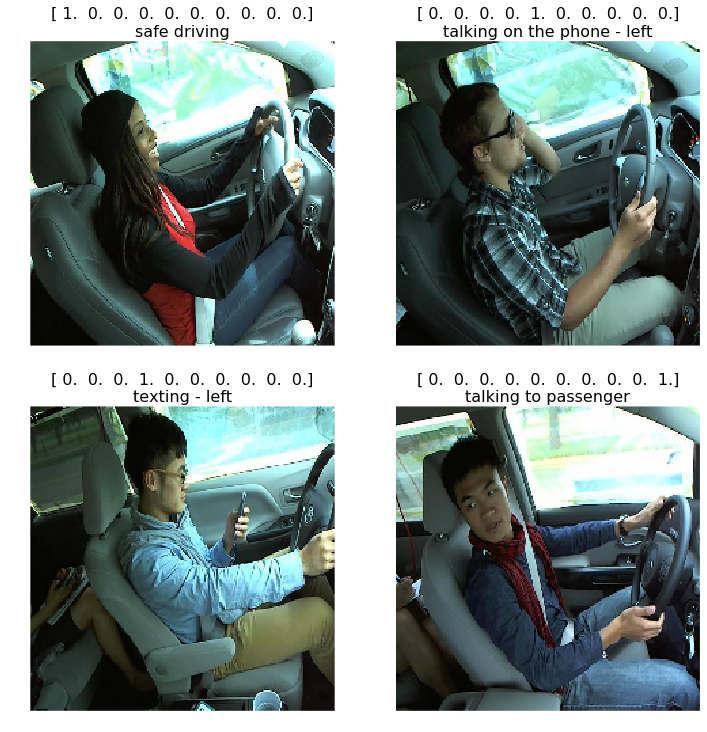

In [4]:
# Load random data and show it.
batch_size = 64
train_batches = vgg.get_batches(train_root)
val_batches = vgg.get_batches(val_root)

imgs,lbls = next(train_batches)
human_lbls = [class_names[np.argmax(lbl)] for lbl in lbls]
titles = ["%s\n%s" % (lbl, human_lbl) for (lbl, human_lbl) in zip(lbls, human_lbls)]
plots(imgs[:4], rows=2, titles=titles[:4], figsize=(12,12))
vgg.predict(imgs[:4])

In [6]:
import keras
from keras.optimizers import Nadam

if train:
  # Prepare the network.
  vgg.finetune(train_batches)
  vgg.model.compile(optimizer=Adam(lr=0.0001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
  # Train on the new data.
  vgg.fit(train_batches, val_batches, nb_epoch = 5)
  vgg.model.save_weights(results_root+"/nadam_e5.h5")
else:
  vgg.model.load_weights(results_root+"/nadam_e5.h5")

Epoch 1/5
20181/20181 [==============================] - 552s - loss: 2.9663 - acc: 0.5120 - val_loss: 0.6722 - val_acc: 0.8399
Epoch 2/5
20181/20181 [==============================] - 551s - loss: 3.0702 - acc: 0.6166 - val_loss: 0.7096 - val_acc: 0.8658
Epoch 3/5
14312/20181 [====================>.........] - ETA: 144s - loss: 3.2124 - acc: 0.6364

KeyboardInterrupt: 

In [7]:
batches, preds = vgg.test(val_root, batch_size = 8)
our_preds = [np.argmax(pred) for pred in preds]
our_readable_labels = [class_names[i] for i in our_preds]
readable_labels = [class_names[i] for i in batches.classes]

def plot_idx(indices, titles):
    plots([image.load_img(val_root + '/' + batches.filenames[i])
           for i in indices],
          figsize=(12,12),
          rows=2,
          titles = titles)

Found 2243 images belonging to 10 classes.


In [8]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(our_preds, batches.classes)

[[237   6   0   8  34   5  10   1   6  22]
 [  1 206   1   5   0   1  12   0   4   1]
 [  3   4 229   0   5   3  11   1   1   1]
 [  1   4   0 211  13   0   1   0   0   0]
 [  0   0   0   2 172   0   0   0   1   0]
 [  0   1   0   0   0 220   1   2   0   2]
 [  0   0   1   1   1   0 172   1   6   0]
 [  1   0   0   1   0   0   0 191   6   0]
 [  0   1   1   3   4   1  21   2 158   6]
 [  6   5   0   4   4   1   4   2   9 181]]


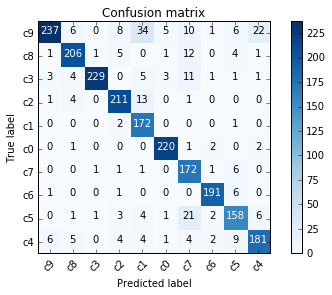

In [9]:
plot_confusion_matrix(cm, batches.class_indices, normalize=False)

In [10]:
# Run the model on the main test set.
filenames = None
if run_tests:
    batches, preds = vgg.test(test_root, batch_size=128)
    filenames = batches.filenames
    save_array(results_root + '/test_preds_nadam.dat', preds)
    save_array(results_root + '/filenames_nadam.dat', filenames)
else:
    preds = load_array(results_root + '/test_preds_nadam.dat')
    filenames = load_array(results_root + '/filenames_nadam.dat')

Found 79726 images belonging to 1 classes.


In [11]:
file_column = [pth[8:] for pth in filenames]
clipped_preds = np.clip(preds, 0.05, 0.95)
preds_column = [','.join(['%.2f' % p for p in pred]) for pred in preds]
entries = [','.join([f, p]) for (f, p) in zip(file_column, preds_column)]
entries = np.array(entries)

class_names = ['c%d' % i for i in range(10)]
title_row = ','.join(['img'] + class_names)
print(entries[:10])

['img_81601.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00'
 'img_14887.jpg,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00'
 'img_62885.jpg,0.00,0.00,0.00,0.00,0.52,0.00,0.01,0.00,0.47,0.00'
 'img_45125.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00'
 'img_22633.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.02,0.00'
 'img_45660.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.01,0.00'
 'img_88962.jpg,0.93,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00'
 'img_92987.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00'
 'img_26932.jpg,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.97'
 'img_57972.jpg,0.00,0.87,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.11']


In [12]:
submission_file_name = 'submission_nadam.csv'
np.savetxt(results_root + '/' + submission_file_name,
           entries, fmt='%s',
           header=title_row,
           comments='')

In [13]:
from IPython.display import FileLink
%cd '/home/ubuntu/nbs/lesson-2'
FileLink('results/' + submission_file_name)

/home/ubuntu/nbs/lesson-2


/home/ubuntu/nbs/lesson-2/results/submission_nadam.csv